In [0]:
!pip install pytesseract==0.3.4
!sudo apt install tesseract-ocr

  Created wheel for pytesseract: filename=pytesseract-0.3.4-py2.py3-none-any.whl size=13431 sha256=efe5fc8671ebbad3030d2ad22d30c1cf074da09c1cca8a60de0d7f09366c12f9
  Stored in directory: /root/.cache/pip/wheels/63/2a/a0/7596d2e0a73cf0aeffd6f6170862c4e73f3763b7827e48691a
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 31 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/

In [0]:
#!python "/content/drive/My Drive/FormProcessing/form.py" "/content/drive/My Drive/FormProcessing/sample_forms/test1.png"

In [0]:
import json
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


class form:
  def __init__(self,dim=(-1,-1)):
    self.Geometry={
            "Width": dim[0],
            "Height": dim[1]
    }
    self.fields=[]
    self.titles=[]
    self.Json=None

  def printForm(self):
    form_image = np.full((self.Geometry["Width"],self.Geometry["Height"],3), 255, dtype=np.uint8)
    # for f in self.fields:
    #   form_image=cv2.rectangle(form_image,f.getbbox(),(251,251,251),-1)

    for l in self.titles:
      i=(l.BoundingBox["Width"]/len(l.text))/20
      form_image = cv2.putText(form_image,l.text, (l.BoundingBox["Left"]+5,l.BoundingBox["Top"]+l.BoundingBox["Height"]-5), fontFace=cv2.FONT_HERSHEY_SIMPLEX ,\
                                           fontScale=i, color=(0,0,0), thickness=int(i),lineType= cv2.LINE_AA,bottomLeftOrigin=False) 
    
    for f in self.fields:
      
      for l in f.labels:
        i=(l.BoundingBox["Width"]/len(l.text))/20
        form_image = cv2.putText(form_image,l.text, (l.BoundingBox["Left"]+5,l.BoundingBox["Top"]+l.BoundingBox["Height"]-5), fontFace=cv2.FONT_HERSHEY_SIMPLEX ,\
                                           fontScale=i, color=(0,0,0), thickness=int(i),lineType= cv2.LINE_AA,bottomLeftOrigin=False) 
      for area in f.fieldArea:
        if area.fieldType=="textField":
          form_image =cv2.rectangle(form_image,(area.BoundingBox["Left"],area.BoundingBox["Top"],area.BoundingBox["Width"],area.BoundingBox["Height"]),(0,0,0),1)
          print(str((area.BoundingBox["Left"],area.BoundingBox["Top"],area.BoundingBox["Width"],area.BoundingBox["Height"])))
        elif area.fieldType=="radio":
          pass
        elif area.fieldType=="date":
          pass
    cv2_imshow(form_image)

  def getJSON(self):
    
    if self.Json is None:
      d=self.__dict__.copy()
      d.pop('Json')

      #convert objects into respective dict

      #1.Title objects
      t1=d.pop('titles')
      d.update({'titles':[]})
      for t2 in t1:
        d['titles'].append(t2.__dict__)

      #2.Field objects
      f1=d.pop('fields')
      d.update({'fields':[]})

      for f2 in f1:
        f3={
            "labels":[],
            "fieldAreas":[]
          }
        for l1 in f2.__dict__['labels']:
          f3["labels"].append(l1.__dict__)
        for fa1 in f2.__dict__['fieldArea']:
          f3["fieldAreas"].append(fa1.__dict__)
        d['fields'].append(f3)
      self.Json=d
      
    print(json.dumps(self.Json,indent=4))

class field:

  def __init__(self, labels=[], fieldArea=[]):
    self.labels=labels
    self.fieldArea=fieldArea
    self.BoundingBox={
            "Left": 0,  
            "Top": 0, 
            "Width": 0,
            "Height": 0
        }

  def getbbox(self):
    # xmin=min(self.labels+self.fieldArea, key=lambda f: f.BoundingBox["Left"])
    # ymin=min(self.labels+self.fieldArea, key=lambda f: f.BoundingBox["Top"])
    # xmax=max(self.labels+self.fieldArea, key=lambda f: f.BoundingBox["Left"]+f.BoundingBox["Width"])
    # ymax=max(self.labels+self.fieldArea, key=lambda f: f.BoundingBox["Top"]+f.BoundingBox["Height"])
    # buf=-10
    x1=min(self.labels+self.fieldArea, key= lambda x:x.BoundingBox["Left"])
    y1=min(self.labels+self.fieldArea, key= lambda x:x.BoundingBox["Top"])
    x2=min(self.labels+self.fieldArea, key= lambda x:x.BoundingBox["Width"])
    y2=min(self.labels+self.fieldArea, key= lambda x:x.BoundingBox["Height"])
    self.BoundingBox = {
            "Left": x1.BoundingBox["Left"],  
            "Top": y1.BoundingBox["Top"],
            "Width": x2.BoundingBox["Width"],
            "Height": y2.BoundingBox["Height"]
        }
    return self.BoundingBox

  def __str__(self):
    return str(self.__dict__)
  def __repr__(self):
    return self.__str__()

    
class genericField:
  def __init__(self, bbox=(0, 0, 0, 0)):
    self.BoundingBox = {
            "Left": bbox[0],  
            "Top": bbox[1], 
            "Width": bbox[2],
            "Height": bbox[3]
        }
  def __str__(self):
    return str(self.__dict__)
  def __repr__(self):
    return self.__str__()


class label(genericField):
  def __init__(self, text=None, bbox=(0, 0, 0, 0)):
    self.text=text
    super(label, self).__init__(bbox)

  
  
class radio(genericField):
  def __init__(self,bbox=(0, 0, 0, 0)):
    self.fieldType="radio"
    super(radio, self).__init__(bbox)


class dateField(genericField):
  def __init__(self, bbox=(0, 0, 0, 0)):
    self.fieldType="date"
    super(dateField, self).__init__(bbox)


class textField(genericField):
  def __init__(self, bbox=( 0, 0, 0, 0)):
    self.fieldType="textField"
    super(textField, self).__init__(bbox)


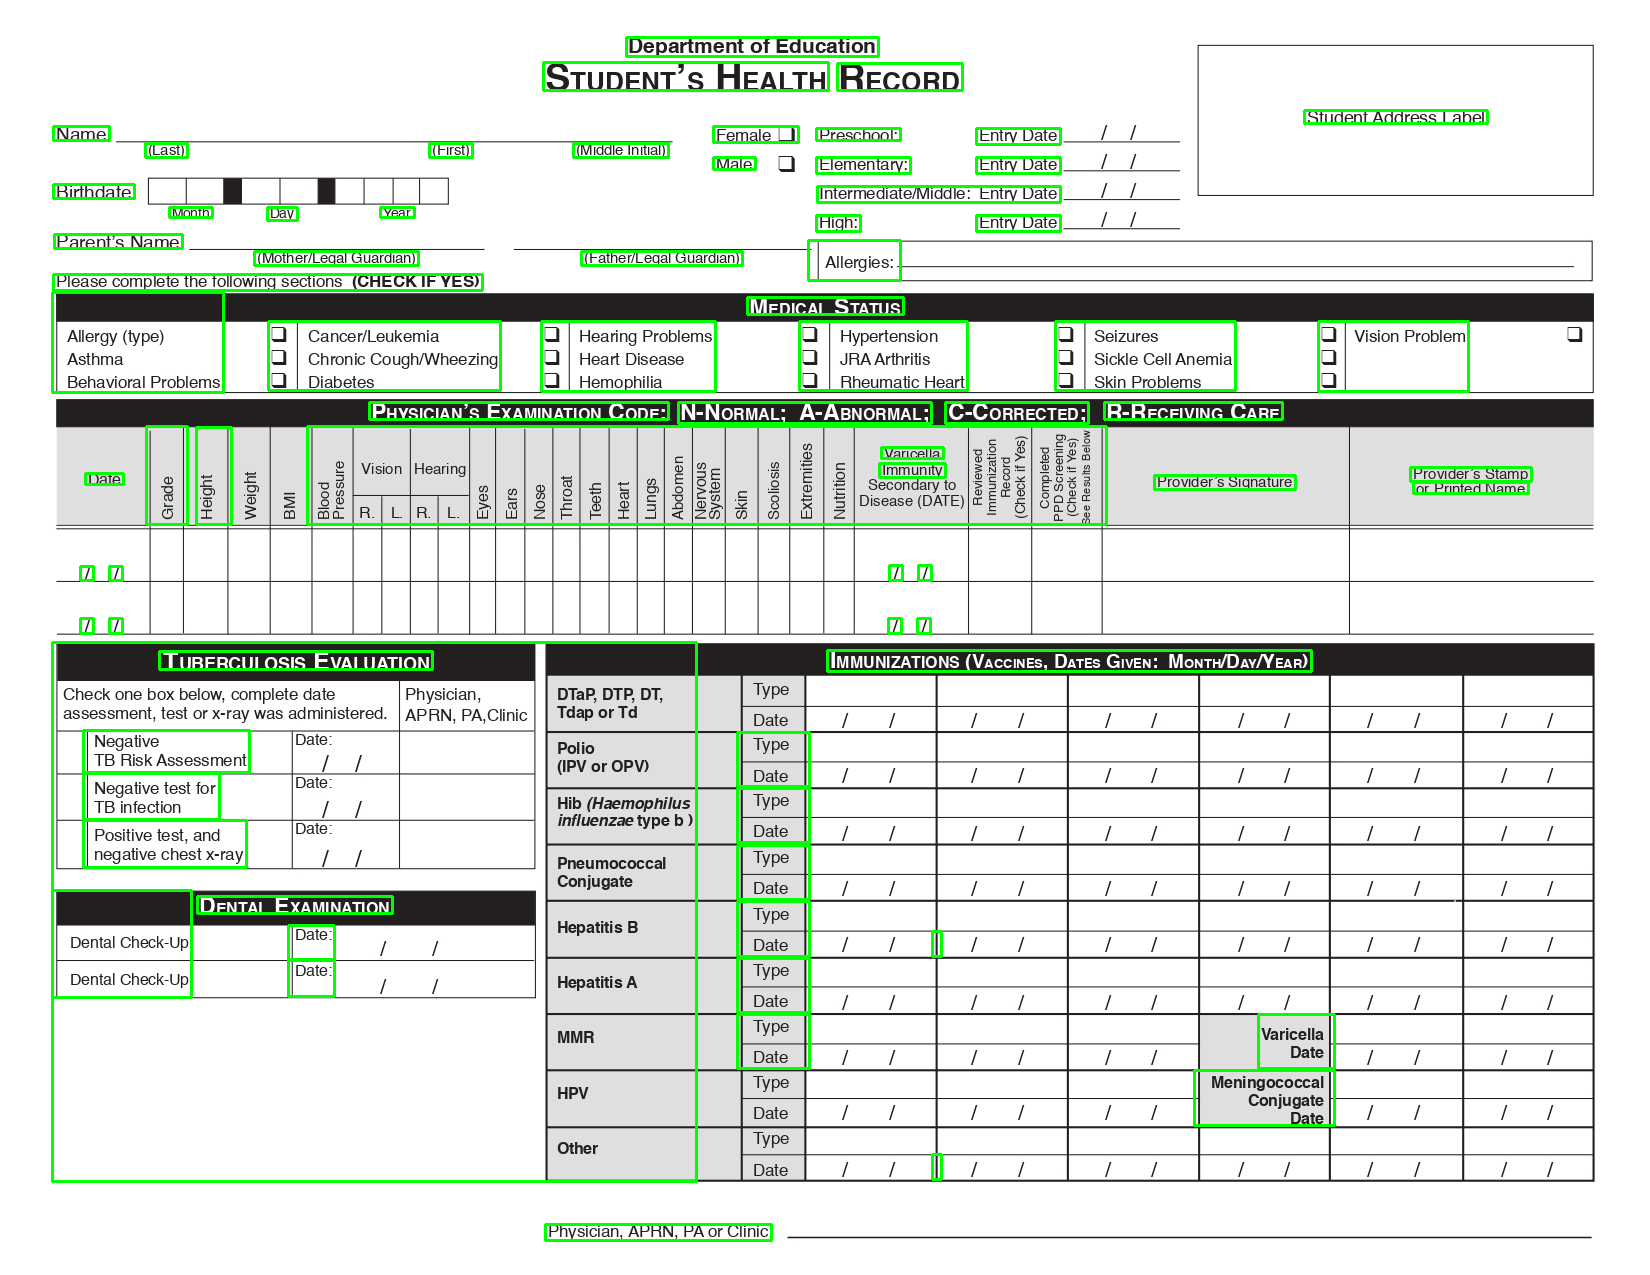

In [0]:
import numpy as np
import cv2
import pytesseract
from PIL import Image
from google.colab.patches import cv2_imshow
import regex as re

rgb = cv2.imread('/content/drive/My Drive/FormProcessing/sample_forms/StudentHealthRecord/StudentHealthRecord_page-0001.jpg')
h = rgb.shape[0]
w = rgb.shape[1]
gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)

kernel = np.ones((1,8), np.uint8)
grad = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)

_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

kernel = np.ones((5,5),np.uint8)
bw = cv2.dilate(bw,kernel,iterations = 1)

contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


count=0
mask = np.zeros(bw.shape, dtype=np.uint8)
text = ""
labels = []
for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    
    if w > 8 and h > 8:
      try:
        new_img = gray[y-1:y+h+1, x-1:x+w+1]
        new_img = cv2.resize(new_img, None, fx=5.5, fy=4.5, interpolation=cv2.INTER_AREA )
        
        new_img = cv2.GaussianBlur(new_img,(5,5),0)
        ret3,new_img = cv2.threshold(new_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        text = pytesseract.image_to_string(new_img,config ='--psm 6')

        if re.search('[a-z0-9]', text, re.IGNORECASE):

          cv2.rectangle(rgb, (x-1, y-1), (x+w-1, y+h-1), (0, 255, 0), 2)
          # count+=1;
          # cv2_imshow(new_img)
          # form_image = np.full(new_img.shape, 255, dtype=np.uint8)
          # h=new_img.shape[0]
          # i=(new_img.shape[1]/len(text))/10
          # form_image = cv2.putText(form_image, text, (10,h-10), fontFace=cv2.FONT_HERSHEY_PLAIN ,\
          #                                 fontScale=i, color=(0,0,0), thickness=int(i),lineType= cv2.LINE_AA,bottomLeftOrigin=False) 
          # cv2_imshow(form_image)

          # print('field '+str(count)+') '+text)
          # print("\n")
          labels.append(label(text,(x-1, y-1, w+1, h+1)))
      except Exception as e:
        print(str(e))

cv2_imshow(rgb)

In [0]:

blurred = cv2.GaussianBlur(gray, (5,5), 0)
ret,thresh1 = cv2.threshold(blurred,244,255,cv2.THRESH_BINARY_INV)

kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(thresh1,kernel,iterations = 1)
# cv2_imshow(thresh1)
# cv2_imshow(erosion)

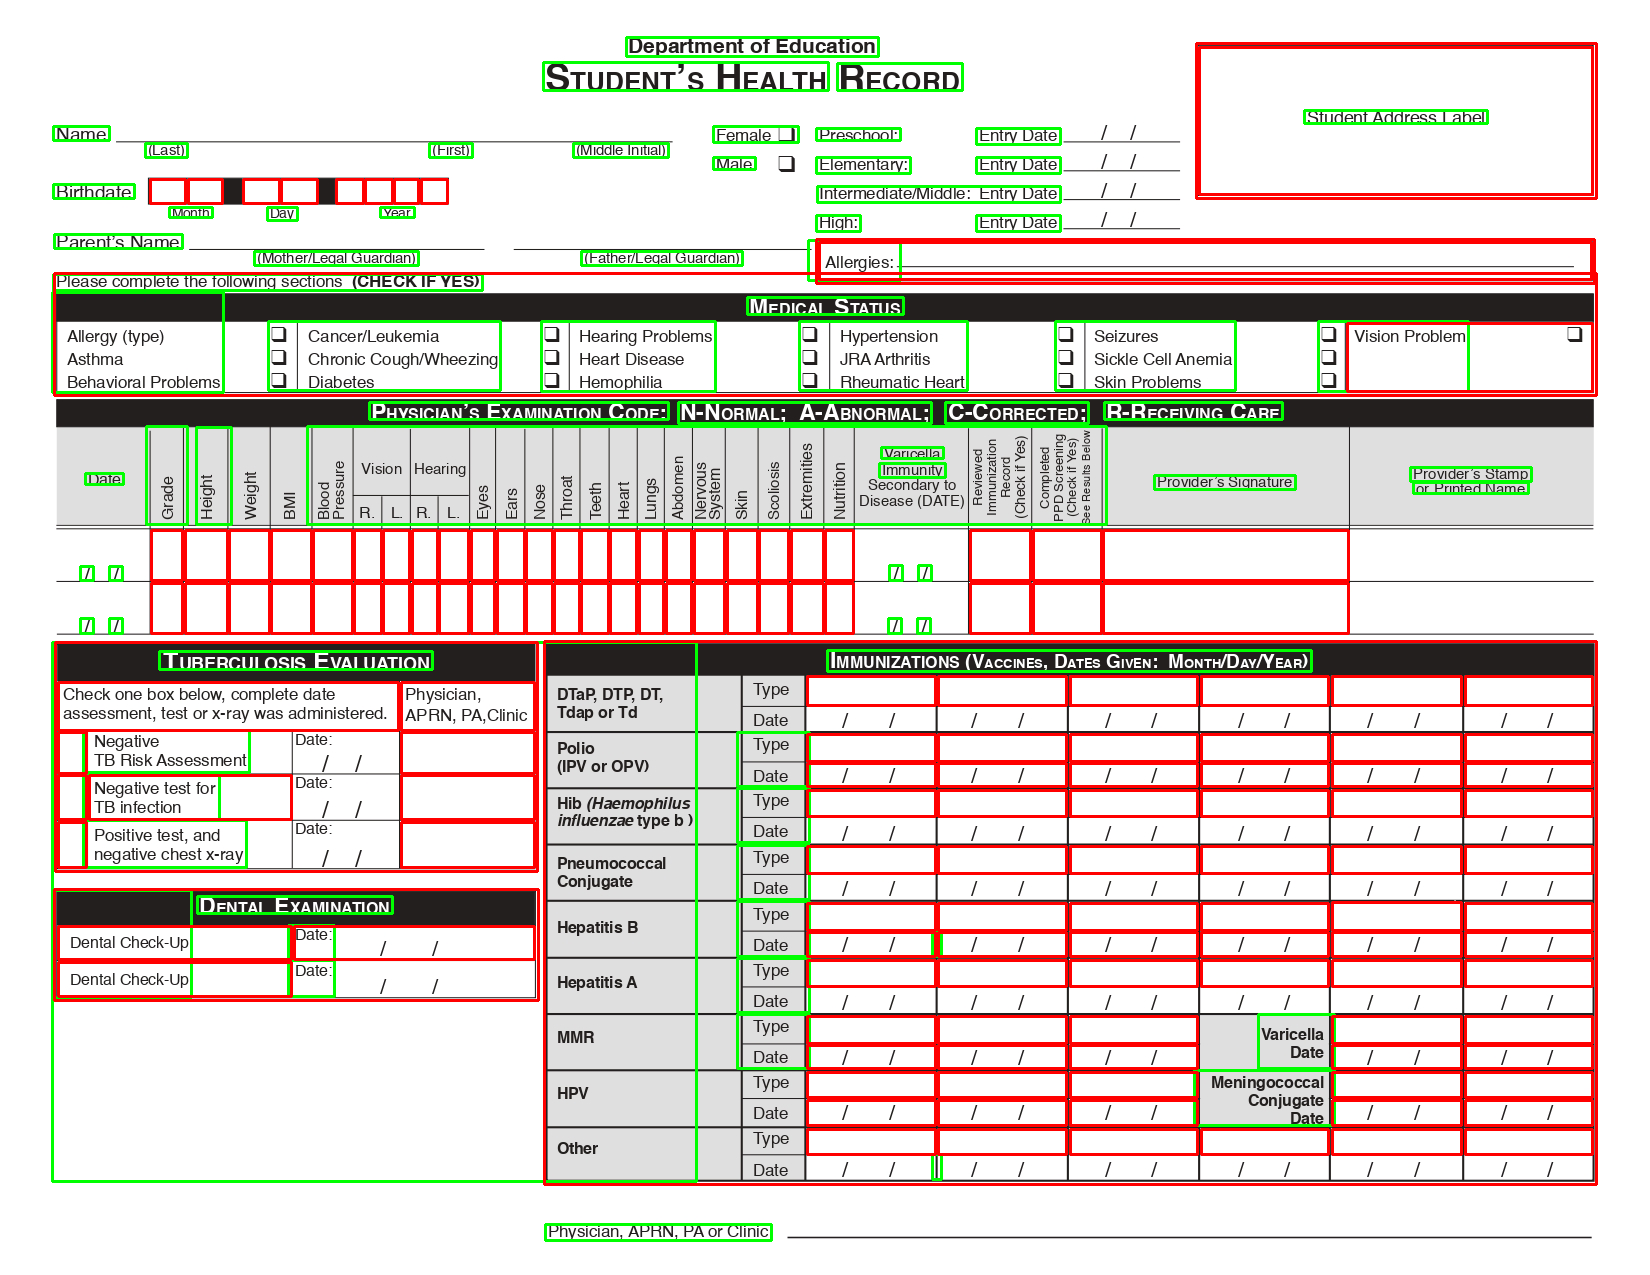

153


In [0]:
contours, hierarchy = cv2.findContours(
    thresh1, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)


res2=rgb.copy()
textFields = []

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w*h>50 and w>5 and h>10 and w*h<thresh1.shape[0]*thresh1.shape[1]*0.5:
      
      peri = cv2.arcLength(c, True)
      approx = cv2.approxPolyDP(c, 0.005 * peri,False)
      # check if the approximated contour has four points
      # if so, it can be labelled as a rectangle
      if len(approx) < 10:
        textFields.append(textField((x,y,w,h)))
        cv2.rectangle(res2,(x,y),(x+w,y+h), (0,0,255), 2)
        #rects.append(approx)


#cv2.drawContours(res2, rects, -1, (0, 0, 255), 2)


cv2_imshow(res2)
print(len(textFields))

In [0]:
textFields.sort(key = lambda x : x.BoundingBox["Top"])
labels.sort(key = lambda x : x.BoundingBox["Top"])

In [0]:
# textFields
textFieldLevels = []
for textFieldObj in textFields:
  if len(textFieldLevels)==0:
    textFieldLevels.append([textFieldObj])
  else:
    if abs(textFieldLevels[-1][-1].BoundingBox["Top"] - textFieldObj.BoundingBox["Top"] ) <=4:
      textFieldLevels[-1].append(textFieldObj)
    else:
      textFieldLevels.append([textFieldObj])


print(len(textFieldLevels))
for l in textFieldLevels:
  l.sort(key=lambda x:x.BoundingBox["Left"])
  print(l)

26
[{'fieldType': 'textField', 'BoundingBox': {'Left': 1196, 'Top': 43, 'Width': 400, 'Height': 155}}, {'fieldType': 'textField', 'BoundingBox': {'Left': 1199, 'Top': 47, 'Width': 393, 'Height': 147}}]
[{'fieldType': 'textField', 'BoundingBox': {'Left': 150, 'Top': 179, 'Width': 35, 'Height': 24}}, {'fieldType': 'textField', 'BoundingBox': {'Left': 188, 'Top': 179, 'Width': 34, 'Height': 24}}, {'fieldType': 'textField', 'BoundingBox': {'Left': 243, 'Top': 179, 'Width': 36, 'Height': 24}}, {'fieldType': 'textField', 'BoundingBox': {'Left': 281, 'Top': 179, 'Width': 36, 'Height': 24}}, {'fieldType': 'textField', 'BoundingBox': {'Left': 336, 'Top': 179, 'Width': 27, 'Height': 24}}, {'fieldType': 'textField', 'BoundingBox': {'Left': 365, 'Top': 179, 'Width': 27, 'Height': 24}}, {'fieldType': 'textField', 'BoundingBox': {'Left': 394, 'Top': 179, 'Width': 24, 'Height': 24}}, {'fieldType': 'textField', 'BoundingBox': {'Left': 421, 'Top': 179, 'Width': 26, 'Height': 24}}]
[{'fieldType': 'textF

In [0]:
# LABELS
labelLevels = []
for labelObj in labels:
  if len(labelLevels)==0:
    labelLevels.append([labelObj])
  else:
    if abs(labelLevels[-1][-1].BoundingBox["Top"] - labelObj.BoundingBox["Top"] ) <=15:
      labelLevels[-1].append(labelObj)
    else:
      labelLevels.append([labelObj])
print(len(labelLevels))
for l in labelLevels:
  l.sort(key=lambda x:x.BoundingBox["Left"])
  print(l)

28
[{'text': 'Department of Education', 'BoundingBox': {'Left': 626, 'Top': 37, 'Width': 253, 'Height': 20}}]
[{'text': 'STUDENT S HEALTH', 'BoundingBox': {'Left': 543, 'Top': 62, 'Width': 286, 'Height': 29}}, {'text': 'RECORD', 'BoundingBox': {'Left': 837, 'Top': 63, 'Width': 126, 'Height': 28}}]
[{'text': 'Student Address Label', 'BoundingBox': {'Left': 1304, 'Top': 110, 'Width': 184, 'Height': 14}}]
[{'text': 'Name', 'BoundingBox': {'Left': 53, 'Top': 126, 'Width': 57, 'Height': 15}}, {'text': '(Last)', 'BoundingBox': {'Left': 145, 'Top': 143, 'Width': 43, 'Height': 15}}, {'text': '(First)', 'BoundingBox': {'Left': 429, 'Top': 143, 'Width': 44, 'Height': 15}}, {'text': '(Middle Initial)', 'BoundingBox': {'Left': 573, 'Top': 143, 'Width': 96, 'Height': 15}}, {'text': 'Female —])', 'BoundingBox': {'Left': 713, 'Top': 126, 'Width': 86, 'Height': 17}}, {'text': 'Male', 'BoundingBox': {'Left': 713, 'Top': 157, 'Width': 43, 'Height': 13}}, {'text': 'Preschool:', 'BoundingBox': {'Left': 81

In [0]:
# def area(w,h):
#   return w*h
# def areaOfIntersetion(bb1,bb2):
#   x1 = max(bb1[0], bb2[0])
#   y1 = max(bb1[1], bb2[1])
#   x2 = min(bb1[0]+bb1[2],bb2[0]+ bb2[2])
#   y2 = min(bb1[1]+bb1[3],bb2[1]+ bb2[3])

#   width = (x2 - x1)
#   height = (y2 - y1)
#   if (width<0) or (height <0):
#     return -1
#   else:
#     return area(width,height)


{'labels': [{'text': 'Department of Education', 'BoundingBox': {'Left': 626, 'Top': 37, 'Width': 253, 'Height': 20}}], 'fieldArea': [{'fieldType': 'textField', 'BoundingBox': {'Left': 1196, 'Top': 43, 'Width': 400, 'Height': 155}}, {'fieldType': 'textField', 'BoundingBox': {'Left': 1199, 'Top': 47, 'Width': 393, 'Height': 147}}], 'BoundingBox': {'Left': 0, 'Top': 0, 'Width': 0, 'Height': 0}}
{'labels': [{'text': 'Student Address Label', 'BoundingBox': {'Left': 1304, 'Top': 110, 'Width': 184, 'Height': 14}}], 'fieldArea': [{'fieldType': 'textField', 'BoundingBox': {'Left': 816, 'Top': 239, 'Width': 778, 'Height': 44}}, {'fieldType': 'textField', 'BoundingBox': {'Left': 819, 'Top': 242, 'Width': 772, 'Height': 37}}], 'BoundingBox': {'Left': 0, 'Top': 0, 'Width': 0, 'Height': 0}}
{'labels': [{'text': 'Name', 'BoundingBox': {'Left': 53, 'Top': 126, 'Width': 57, 'Height': 15}}, {'text': '(Last)', 'BoundingBox': {'Left': 145, 'Top': 143, 'Width': 43, 'Height': 15}}, {'text': '(First)', 'Boun

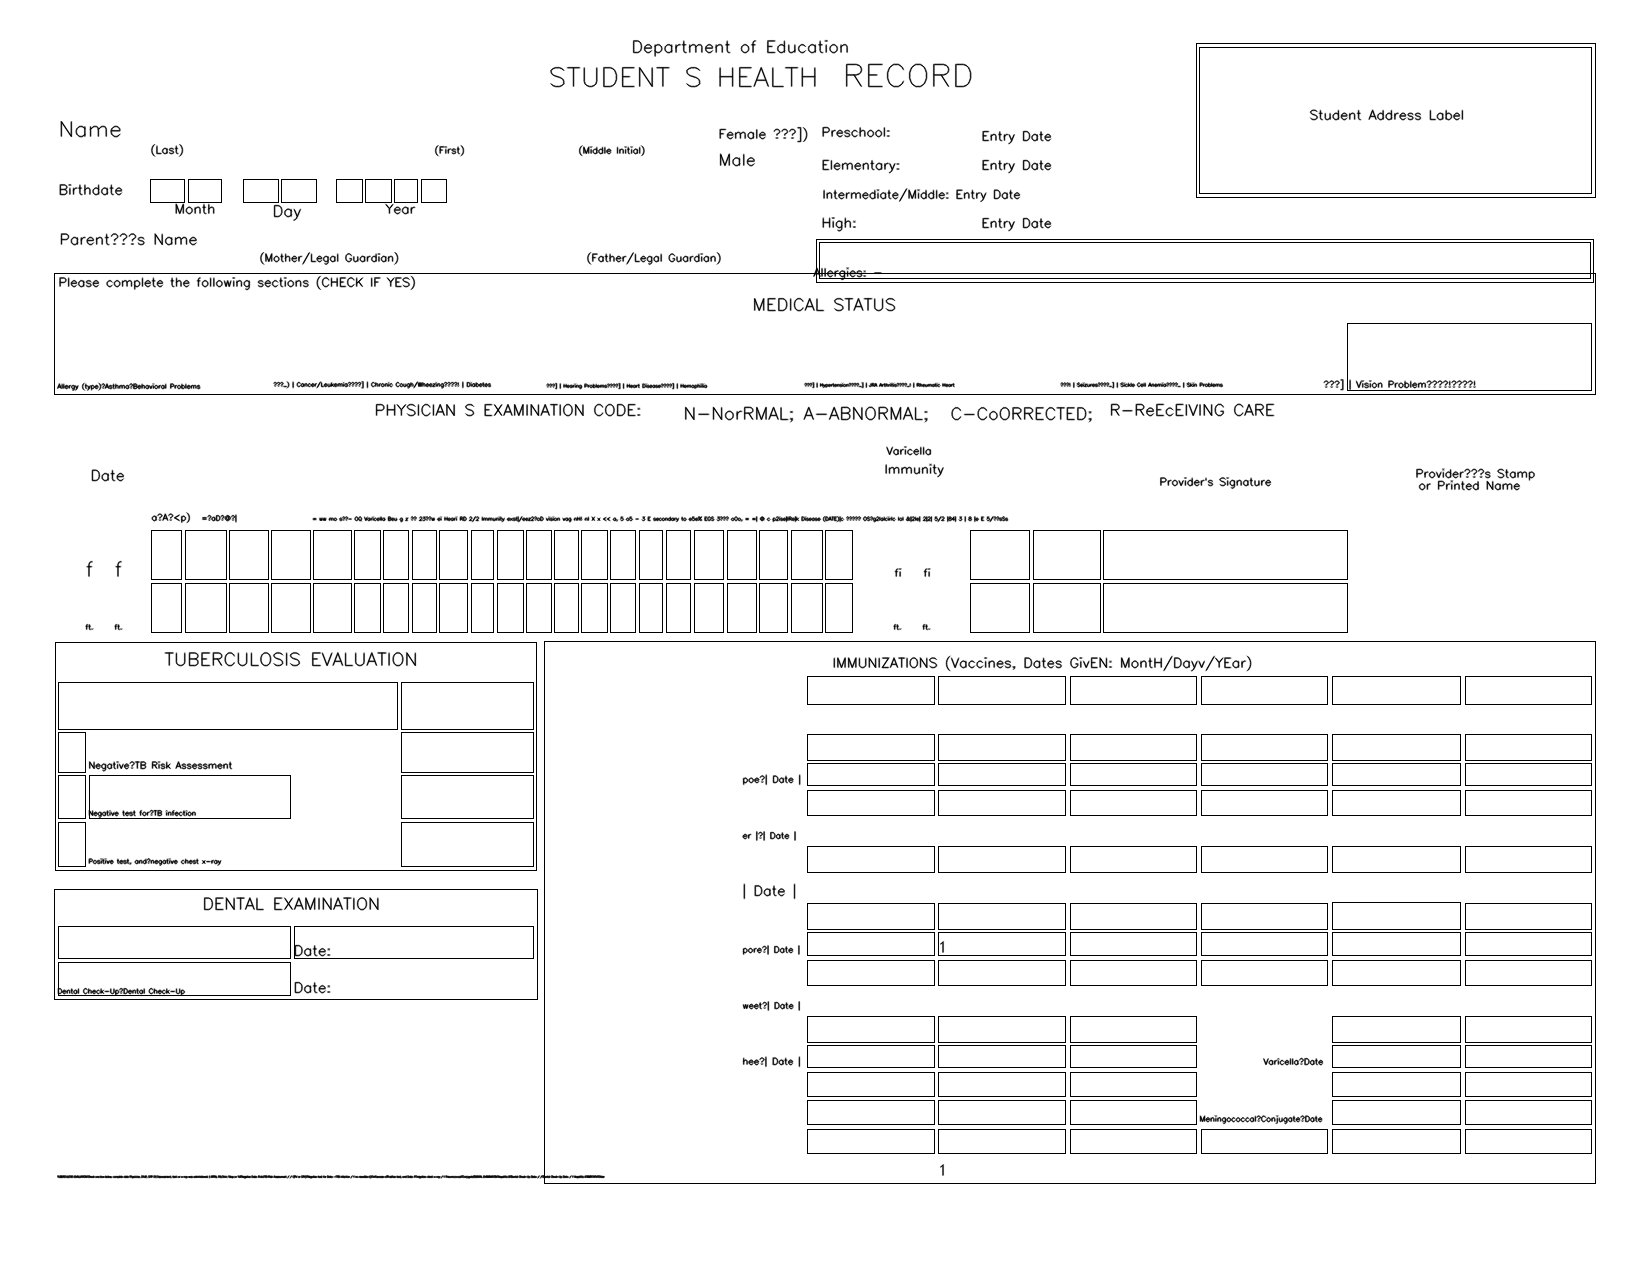

In [0]:

new_form=form(dim=rgb.shape[:2])

for labelLevel in labelLevels:

  textFieldLevelSelected=False
  

  for textFieldLevel in textFieldLevels:
      if labelLevel[0].BoundingBox["Top"]-textFieldLevel[0].BoundingBox["Top"]<=4:
          textFieldLevelSelected=True
          textFieldLevels.remove(textFieldLevel)
          break

  if textFieldLevelSelected == False:
      new_form.titles += labelLevel
      labelLevels.remove(labelLevel)

  else:
      if len(labelLevel) == 1 or len(textFieldLevel)==1:
          new_form.fields.append(field(labelLevel,textFieldLevel))
          print(new_form.fields[-1])

      elif len(labelLevel) == len(textFieldLevel):
          for (l,f) in zip(labelLevel, textFieldLevel): 
              new_form.fields.append(field([l],[f]))
              print(new_form.fields[-1])

      elif len(labelLevel)==0:
        continue

      elif len(textFieldLevel)==0:
        new_form.fields.append(field(labelLevel,[]))
        print(new_form.fields[-1])

      else:
        mapping={}
        if len(labelLevel) > len(textFieldLevel):
          for labelObj in labelLevel:
            mapping.update({labelObj:min(textFieldLevel , key=lambda x: min(abs(x.BoundingBox["Left"]-labelObj.BoundingBox["Left"]),abs(x.BoundingBox["Left"]+x.BoundingBox["Width"]-labelObj.BoundingBox["Left"])))})
          for textFieldObj in textFieldLevel:
            labell= [ x for x in mapping.keys() if  mapping[x] == textFieldObj ] 
            new_form.fields.append(field(labell,[textFieldObj]))
        else:
          for textFieldObj in textFieldLevel:
            mapping.update({textFieldObj:min(labelLevel , key=lambda x: min(abs(x.BoundingBox["Left"]-textFieldObj.BoundingBox["Left"]),abs(x.BoundingBox["Left"]+x.BoundingBox["Width"]-textFieldObj.BoundingBox["Left"])))})
          for labelObj in labelLevel:
            textFieldl= [ x for x in mapping.keys() if  mapping[x] == labelObj ] 
            new_form.fields.append(field([labelObj],textFieldl))
  
new_form.printForm()

In [0]:
new_form.getJSON()

{
    "Geometry": {
        "Width": 1275,
        "Height": 1650
    },
    "titles": [
        {
            "text": "1",
            "BoundingBox": {
                "Left": 932,
                "Top": 1154,
                "Width": 10,
                "Height": 26
            }
        }
    ],
    "fields": [
        {
            "labels": [
                {
                    "text": "Department of Education",
                    "BoundingBox": {
                        "Left": 626,
                        "Top": 37,
                        "Width": 253,
                        "Height": 20
                    }
                }
            ],
            "fieldAreas": [
                {
                    "fieldType": "textField",
                    "BoundingBox": {
                        "Left": 1196,
                        "Top": 43,
                        "Width": 400,
                        "Height": 155
                    }
                },
                {
 

In [0]:
!unzip "/content/drive/My Drive/iLovePDF/ilovepdf_pages-to-jpg.zip"

unzip:  cannot find or open /content/drive/My Drive/iLovePDF/ilovepdf_pages-to-jpg.zip, /content/drive/My Drive/iLovePDF/ilovepdf_pages-to-jpg.zip.zip or /content/drive/My Drive/iLovePDF/ilovepdf_pages-to-jpg.zip.ZIP.


In [0]:
!rm -r "/content/drive/My Drive/iLovePDF"

rm: cannot remove '/content/drive/My Drive/iLovePDF': No such file or directory
